EDA YELP

In [23]:
import pandas as pd
from pandas import json_normalize
import folium
from folium.plugins import MarkerCluster


# Especifica la ruta del archivo Parquet
ruta_parquet = "restaurants.parquet"

# Lee el archivo Parquet en un DataFrame
df = pd.read_parquet(ruta_parquet)

# Define una función para evaluar la cadena y manejar casos nulos
def safe_eval(attr):
    try:
        if pd.notna(attr) and isinstance(attr, str):
            return eval(attr)
        else:
            return {}
    except:
        return {}

# Normaliza 'attributes' usando la función safe_eval
df_attributes = json_normalize(df['attributes'].apply(safe_eval))


# Configura pandas para mostrar todas las columnas
pd.set_option('display.max_columns', None) # Convierte temporalmente todas las columnas a cadena para la visualización
df_str = df.applymap(lambda x: str(x))

df = df.drop(['address', 'postal_code'], axis=1)

# Elimina filas con valores NaN
df = df.dropna()


# Restaura la configuración original de pandas después de imprimir
pd.reset_option('display.max_columns')

# Muestra todas las filas y columnas del DataFrame como una cadena
print(df_str.head(1).to_string())

# Muestra las primeras filas del DataFrame después de las correcciones
print(df.head(2))
print(df.columns)







              business_id                name      address          city state postal_code    latitude    longitude stars review_count is_open                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [5]:
# Resumen estadístico del DataFrame
print(df.describe())

           latitude     longitude         stars  review_count       is_open
count  30994.000000  30994.000000  30994.000000  30994.000000  30994.000000
mean      36.122803    -86.586183      3.538572    100.726721      0.700619
std        4.936693     12.762642      0.824198    204.106030      0.457994
min       27.579476   -120.001095      1.000000      5.000000      0.000000
25%       30.012604    -90.116379      3.000000     17.000000      0.000000
50%       38.682848    -82.787288      3.500000     42.000000      1.000000
75%       39.948910    -75.321985      4.000000    108.000000      1.000000
max       43.773686    -74.664459      5.000000   7568.000000      1.000000


Aca podemos ver los estados y las ciudades con sus respectivos restaurantes, hay un dato determinante y es el numero de negocios que vemos en el sector ESTE del pais VS el OESTE, en el primero estan el 92% de restauranres en el segundo esta solo el 8%, las oportunidades en ambos es evidente, un sector por descubrir y explotar y por otro lado un sector mas competitivo y con mayor ingresos por turismo y ocio.

In [6]:
# Filtrar por restaurantes con al menos una estrella
df_over_one_star = df[df['stars'] >= 1.0]

# Agrupar por estado y contar el número de restaurantes
restaurant_count_by_state = df_over_one_star.groupby('state').size().reset_index(name='restaurant_count')

# Crear un mapa
m = folium.Map(location=[37.7749, -122.4194], zoom_start=4)

# Añadir marcadores al mapa
marker_cluster = MarkerCluster().add_to(m)

for index, row in restaurant_count_by_state.iterrows():
    state_df = df[df['state'] == row['state']]
    
    if not state_df.empty:
        folium.Marker(
            location=[state_df['latitude'].iloc[0], state_df['longitude'].iloc[0]],
            popup=f"{row['state']}: {row['restaurant_count']} restaurantes",
            icon=None,
            tooltip=f"{row['restaurant_count']} restaurantes"
        ).add_to(marker_cluster)

# Añadir leyenda
legend_html = """
     <div style="position: fixed; 
     bottom: 50px; left: 50px; width: 100px; height: 90px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; opacity: .85;
     ">
     &nbsp; <b> Leyenda</b> <br>
     &nbsp; Al menos 1 Estrella &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:red"></i><br>
     </div>
     """

m.get_root().html.add_child(folium.Element(legend_html))

# Mostrar el mapa
m




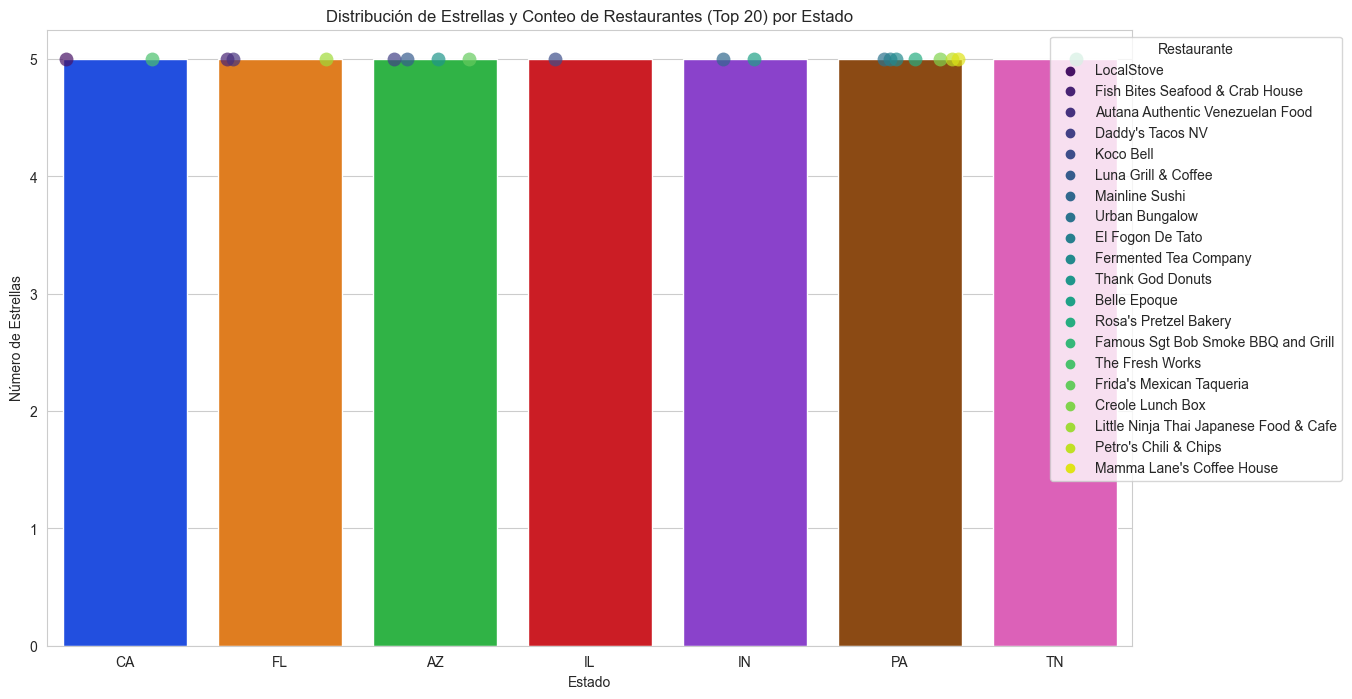

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ordena el DataFrame por número de estrellas en orden descendente y toma los primeros 20
top_20_restaurants = df.sort_values(by='stars', ascending=False).head(20)

# Gráfico de barras agrupadas con colores distintivos
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
palette = sns.color_palette("bright", n_colors=len(top_20_restaurants['state'].unique()))

# Gráfico de barras
bars = sns.barplot(x='state', y='stars', data=top_20_restaurants, errorbar=None, palette=palette)

# Gráfico de puntos para el conteo de restaurantes
sns.stripplot(x='state', y='stars', hue='name', data=top_20_restaurants, size=10, palette='viridis', alpha=0.7, dodge=True, ax=bars)

# Ajustes de etiquetas y título
plt.title('Distribución de Estrellas y Conteo de Restaurantes (Top 20) por Estado')
plt.xlabel('Estado')
plt.ylabel('Número de Estrellas')

# Ajustes de leyenda
handles, labels = bars.get_legend_handles_labels()
bars.legend(handles[0:len(top_20_restaurants)], labels[0:len(top_20_restaurants)], title='Restaurante', loc='upper right', bbox_to_anchor=(1.2, 1))

plt.show()

In [8]:
import pandas as pd
from textblob import TextBlob
import nltk
nltk.download('punkt')

# Especifica la ruta del archivo Parquet
ruta_parquet = "reviews.parquet"

# Lee el archivo Parquet en un DataFrame
df1 = pd.read_parquet(ruta_parquet)

# Crear una función para análisis de sentimiento
def analisis_sentimiento(texto):
    if texto is not None:  # Añade esta comprobación para manejar valores nulos
        analysis = TextBlob(texto)
        # La polaridad mide la positividad o negatividad del texto (-1 a 1)
        # El sujeto mide la objetividad del texto (0 a 1, donde 0 es muy subjetivo)
        return analysis.sentiment.polarity, analysis.sentiment.subjectivity
    else:
        return None, None

# Aplicar la función a la columna 'text' y obtener dos nuevas columnas
df1[['sentimiento_polaridad', 'sentimiento_subjetividad']] = df1['text'].apply(analisis_sentimiento).apply(pd.Series)


# Elimina las filas con al menos un valor nulo en cualquier columna
df1 = df1.dropna()

print(df1.head(3))
               



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                  user_id            name        time  rating   
7   113712248430587773659  Liz Caratachea  2021-07-18       3  \
8   113918395476134636613      V Macinnis  2021-05-09       5   
10  107847800790945286690     Anders Berg  2021-07-28       5   

                                                 text   
7   Nice place but this is Brigittes last laugh\nN...  \
8   The best karaoke I've been to. Its like watchi...   
10  Great Karaoke in N. Phoenix with many song cho...   

                                                 resp   
7   {'text': 'Yes. Our Karaoke Company is inside B...  \
8   {'text': 'Thanks for your kind review. I hope ...   
10  {'text': 'Thanks for your kind review Anders
H...   

                                  gmap_id  sentimiento_polaridad   
7   0x872b71e9e839f35d:0xe552979de157b4d9               0.417187  \
8   0x872b71e9e839f35d:0xe552979de157b4d9               0.500000   
10  0x872b71e9e839f35d:0xe552979de157b4d9               0.650000   

    sent

Se visualiza la evolucion de revisiones y la distribucion de calificaciones, desde el año 2017 hasta el año 2020 de una manera ascedente, luego por situaciones de pandemia y por el cierre de los negocios al publico, se visualiza un decrecimiento del sector y por ende en la evolucion de recomendaciones incrementandose nuevamente en el año 2021 cuando se empezo abrir al publico.

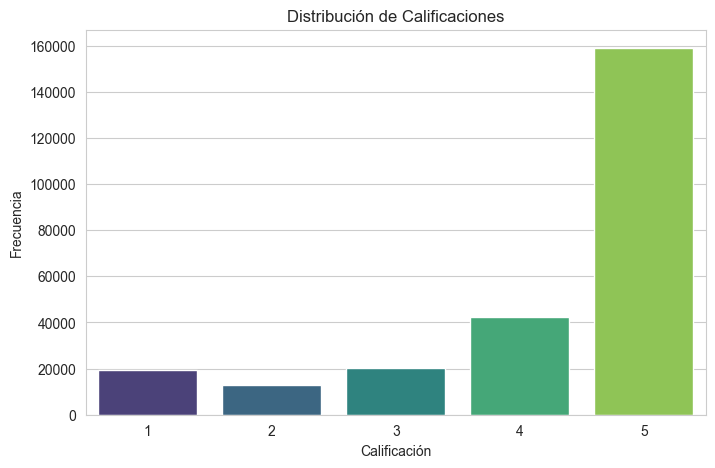

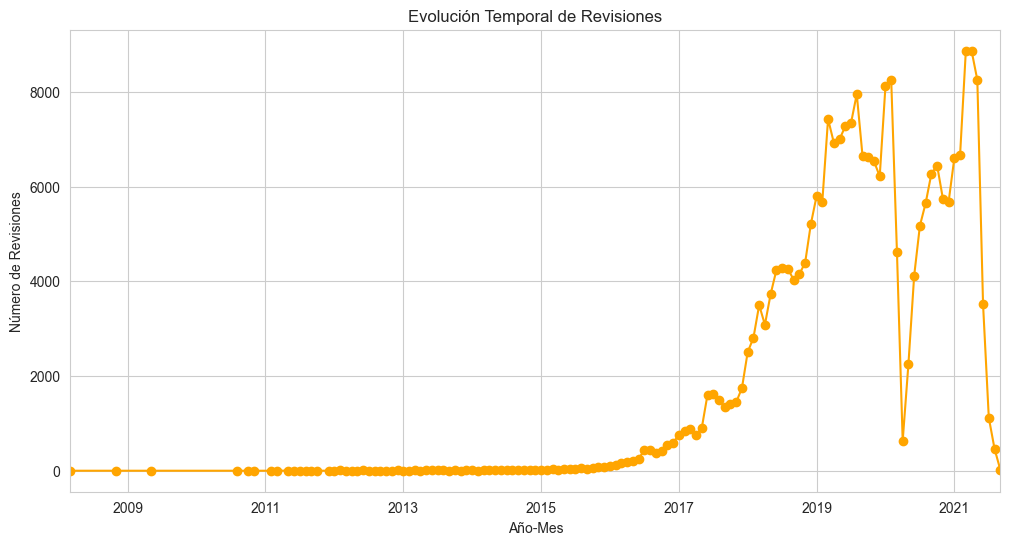

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Punto 1: Distribución de Calificaciones
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=df1, palette='viridis')
plt.title('Distribución de Calificaciones')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.show()

# Punto 2: Evolución Temporal de las Revisiones
df1['time'] = pd.to_datetime(df1['time'])
df1['year_month'] = df1['time'].dt.to_period('M')

plt.figure(figsize=(12, 6))
df1.groupby('year_month').size().plot(marker='o', color='orange')
plt.title('Evolución Temporal de Revisiones')
plt.xlabel('Año-Mes')
plt.ylabel('Número de Revisiones')
plt.show()

En este contexto, "ratings" generalmente se refiere a las calificaciones que los usuarios o clientes han asignado a los restaurantes. Estas calificaciones suelen ser valores numéricos, por ejemplo, en una escala del 1 al 5, donde 1 puede representar una experiencia insatisfactoria y 5 una experiencia excelente, es predominante la calidad del servicio como se evidencia en el grafico por la puntuacion de 5.

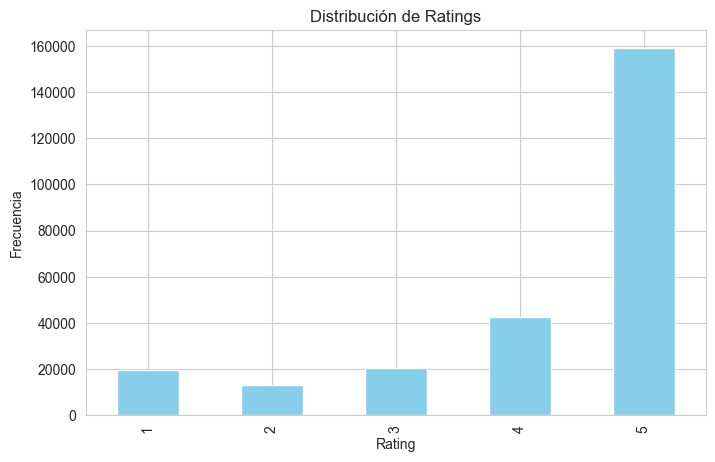

In [10]:
# Distribución de Ratings:
plt.figure(figsize=(8, 5))
df1['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribución de Ratings')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.show()

Generalmnete los usuarios tienen un solo comentario cuando de sugerencias o calificaciones al servicio se refiere, este es el valor determinante, pero podemos encontrar usuarios con 2, 3, 4 y hasta 5 comentarios.

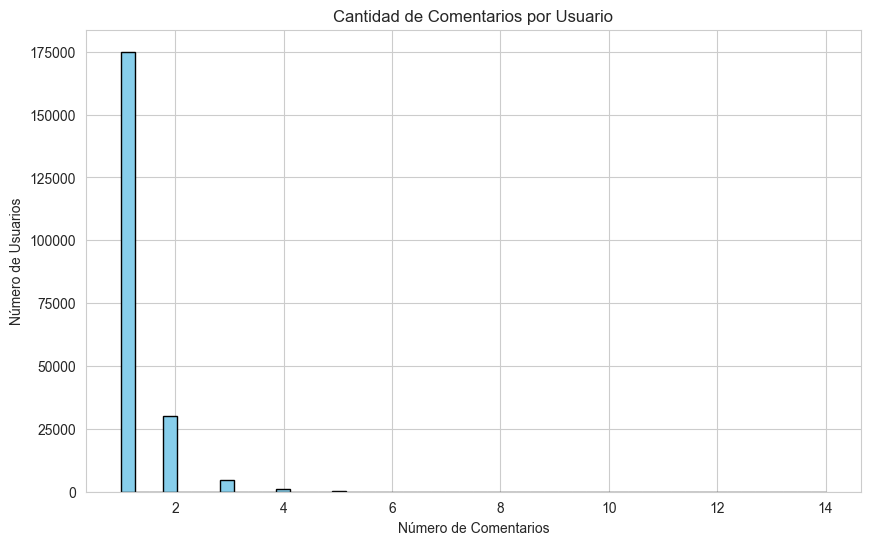

In [12]:
# Cantidad de Comentarios por Usuario
user_comment_counts = df1['user_id'].value_counts()

plt.figure(figsize=(10, 6))
user_comment_counts.hist(bins=50, color='skyblue', edgecolor='black')
plt.title('Cantidad de Comentarios por Usuario')
plt.xlabel('Número de Comentarios')
plt.ylabel('Número de Usuarios')
plt.show()

Cuando los valores son negativos hay una polaridad o una percepcion negativa en cuanto al restaurante, si estan ubicados en cero es neutral y valores positivos como lo vemos en el grafico que son los predominantes, dan a entender una buena percepcion  positiva en los restaurantes evaluados.

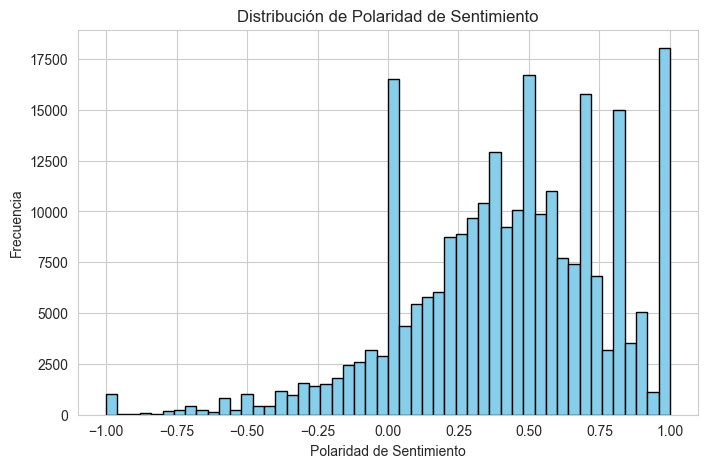

In [13]:
# Análisis de Sentimiento:
# Visualiza la distribución del sentimiento en los comentarios.

plt.figure(figsize=(8, 5))
df1['sentimiento_polaridad'].hist(bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de Polaridad de Sentimiento')
plt.xlabel('Polaridad de Sentimiento')
plt.ylabel('Frecuencia')
plt.show()

Las puntuaciones y la polaridad de sentimiento son directamente proporcionales, ambas se ubican de una forma ascedente y quiere decir que son excelentes las puntuaciones y los comentarios o calificaciones del restaurante, hay positividad en la percepcion, en el servicio y la calidad.

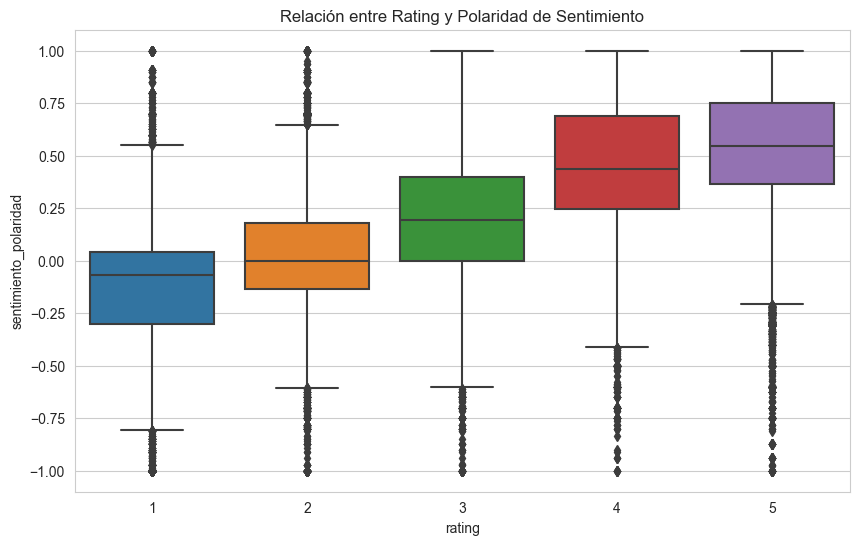

In [14]:
# Relación entre Rating y Sentimiento:
# Comprende si hay alguna relación entre la calificación dada y la polaridad de sentimiento.

plt.figure(figsize=(10, 6))
sns.boxplot(x='rating', y='sentimiento_polaridad', data=df1)
plt.title('Relación entre Rating y Polaridad de Sentimiento')
plt.show()

En el mapa de correlacion se evidencia el crecimiento en opiniones positivas versus las otras variables, todas actuan de una manera ascedente con sentimientos objetivos y positivos.

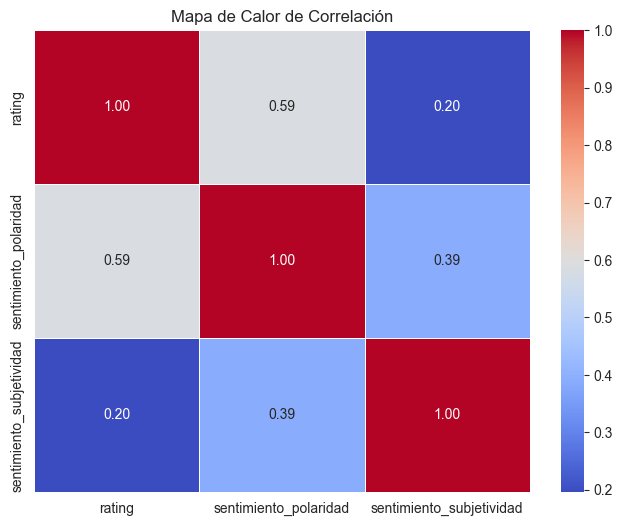

In [15]:
#correlación entre variables numéricas, la variable "rating" como las columnas derivadas del análisis de 
# sentimiento ("sentimiento_polaridad" y "sentimiento_subjetividad") son numéricas y podrían utilizarse 
# para crear un mapa de calor.   

# Seleccionar las columnas relevantes
columnas_para_mapa_de_calor = ['rating', 'sentimiento_polaridad', 'sentimiento_subjetividad']

# Calcular la matriz de correlación
matriz_correlacion = df1[columnas_para_mapa_de_calor].corr()

# Crear un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Mapa de Calor de Correlación')
plt.show()

In [16]:
# Especifica la ruta del archivo Parquet
ruta_parquet = "users.parquet"

# Lee el archivo Parquet en un DataFrame
df2 = pd.read_parquet(ruta_parquet)

df2 = df2.reset_index(drop=True)

print(df2.head(5))
print(df2.columns)

                  user_id      name  review_count yelping_since  average_stars
0  cxuxXkcihfCbqt5Byrup8Q       Rob            12    2009-02-24           2.75
1  iYzhPPqnrjJkg1JHZyMhzA     Chris             4    2010-11-03           4.00
2  vVukUtqoLF5BvH_VtQFNoA  Charlene            37    2011-01-29           4.51
3  _crIokUeTCHVK_JVOy-0qQ     Kenny            11    2009-10-07           3.08
4  1McG5Rn_UDkmlkZOrsdptg    Teresa             7    2009-05-26           4.29
Index(['user_id', 'name', 'review_count', 'yelping_since', 'average_stars'], dtype='object')


Review_count:

Count: Hay 1,752,308 observaciones en la columna review_count. Esto indica  información de revisión para esa cantidad de usuarios.
Mean (media): La cantidad promedio de revisiones por usuario es aproximadamente 7.89.
Std (desviación estándar): La desviación estándar es aproximadamente 8.58, lo que sugiere una variabilidad considerable en la cantidad de revisiones entre los usuarios.
Min (mínimo): El usuario con la menor cantidad de revisiones tiene 0 revisiones.
25% (percentil 25): El 25% de los usuarios tienen 2 o menos revisiones.
50% (percentil 50 o mediana): La mitad de los usuarios tienen 4 o menos revisiones.
75% (percentil 75): El 75% de los usuarios tienen 11 o menos revisiones.
Max (máximo): El usuario con la mayor cantidad de revisiones tiene 39 revisiones.
average_stars:

Count: Hay 1,752,308 observaciones en la columna average_stars. Esto indica  información de calificación promedio para esa cantidad de usuarios.
Mean (media): La calificación promedio entre los usuarios es aproximadamente 3.60.
Std (desviación estándar): La desviación estándar es aproximadamente 1.24, lo que sugiere cierta variabilidad en las calificaciones promedio entre los usuarios.
Min (mínimo): La calificación promedio más baja es 1.
25% (percentil 25): El 25% de los usuarios tienen una calificación promedio de 3 o menos.
50% (percentil 50 o mediana): La mitad de los usuarios tienen una calificación promedio de 3.88 o menos.
75% (percentil 75): El 75% de los usuarios tienen una calificación promedio de 4.67 o menos.
Max (máximo): La calificación promedio más alta es 5.

In [18]:
df2.describe()

,review_count,average_stars
count,1.752308e+06,1.752308e+06
mean,7.885000e+00,3.602509e+00
std,8.579997e+00,1.243534e+00
min,0.000000e+00,1.000000e+00
25%,2.000000e+00,3.000000e+00
50%,4.000000e+00,3.880000e+00
75%,1.100000e+01,4.670000e+00
max,3.900000e+01,5.000000e+00


Review_count (Cantidad de Reseñas):

Esta métrica indica la cantidad total de reseñas que un restaurante ha recibido. Cada vez que un usuario escribe una reseña sobre el restaurante, se incrementa este contador. Una mayor cantidad de reseñas generalmente sugiere una mayor popularidad o notoriedad del restaurante.

Average_stars (Promedio de Estrellas):

Esta métrica representa el promedio de todas las calificaciones (estrellas) que los usuarios han asignado al restaurante. Por lo general, los usuarios dan calificaciones en una escala específica, como 1 a 5 estrellas, donde 1 puede indicar una experiencia insatisfactoria y 5 una experiencia excelente. Un average_stars más alto generalmente sugiere que los usuarios han tenido experiencias más positivas en promedio.

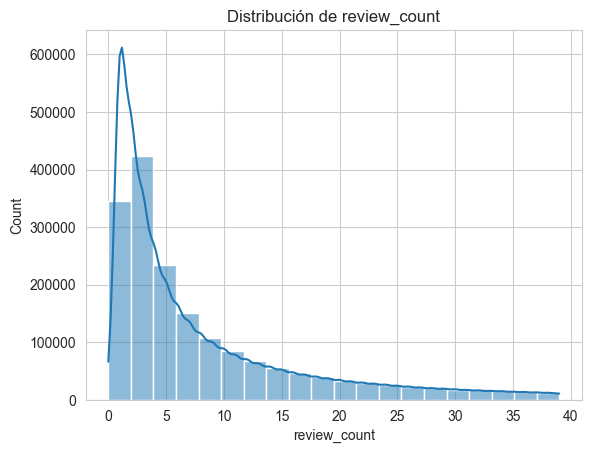

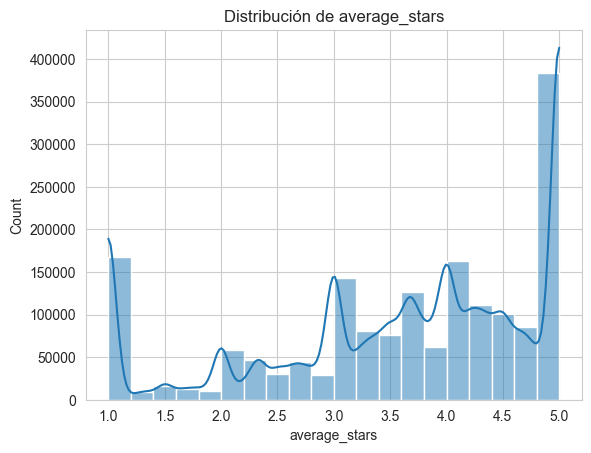

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df2['review_count'], bins=20, kde=True)
plt.title('Distribución de review_count')
plt.show()

sns.histplot(df2['average_stars'], bins=20, kde=True)
plt.title('Distribución de average_stars')
plt.show()

Variables directamente proporcionales de manera ascedente, se observa que crecen los comentarios y las calificaciones de forma positiva.

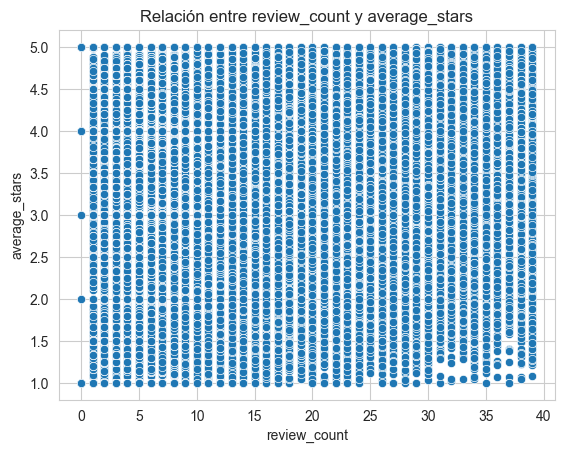

In [21]:
sns.scatterplot(x='review_count', y='average_stars', data=df2)
plt.title('Relación entre review_count y average_stars')
plt.show()

Este fragmento de código realiza varias operaciones para analizar la distribución de usuarios en función del año en que se registraron en Yelp. 
Se observa que para los años 2006 a 2015 el crecimeinto fue exponencial, a partir de este año hasta la fecha los registros fueron descendiendo y esto es por factores economicos y en variabilidad del consumo.

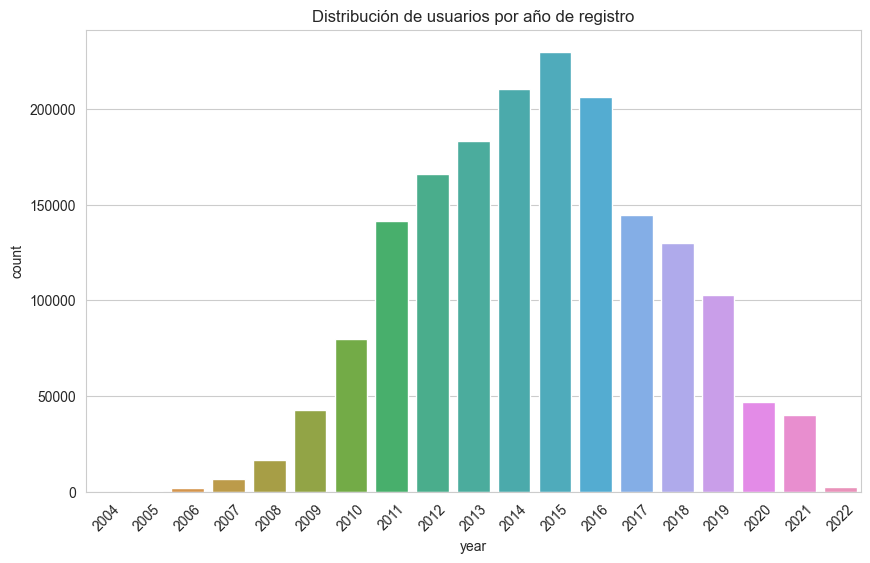

In [22]:
df2['yelping_since'] = pd.to_datetime(df2['yelping_since'])
df2['year'] = df2['yelping_since'].dt.year

# Ajustar el tamaño del gráfico
plt.figure(figsize=(10, 6))

# Crear el gráfico de barras
sns.countplot(x='year', data=df2)

# Rotar las etiquetas del eje x
plt.xticks(rotation=45)

# Añadir título al gráfico
plt.title('Distribución de usuarios por año de registro')

# Mostrar el gráfico
plt.show()